In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
with open('../python/methods.py', 'r') as file:
    exec(file.read())

with open('../python/methods_for_r.py', 'r') as file:
    exec(file.read())

In [29]:
samples = pd.read_csv('../sample_sheet.csv')
samples = samples[ samples['Region'] == 'S1_L23' ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location
0,W1_C1,W1,C1,S1_L23,2019 12 09,177.265396,180,W1/C1
1,W1_C2,W1,C2,S1_L23,2019 12 09,265.898093,270,W1/C2
2,W1_C8,W1,C8,S1_L23,2019 12 10,315.138481,320,W1/C8
3,W2_C3,W2,C3,S1_L23,2019 12 12,236.353861,240,W2/C3
4,W2_C4,W2,C4,S1_L23,2019 12 12,285.594248,290,W2/C4
5,W2_C5,W2,C5,S1_L23,2019 12 12,408.695218,415,W2/C5
6,W2_C6,W2,C6,S1_L23,2019 12 12,196.961551,200,W2/C6
7,W3_C10,W3,C10,S1_L23,2019 12 18,364.378869,370,W3/C10
8,W3_C11,W3,C11,S1_L23,2019 12 18,226.505783,230,W3/C11
9,W4_C10,W4,C10,S1_L23,2019 12 18,206.809628,210,W4/C10


In [30]:
def read_sample_event_data(sample_name, time_shift = 0, event_length = 0.25):
    """
    Reads sample event data.
    
    :param sample_name: Sample identifier.
    :param movement: Whether to read movement or no movement data.
    :param time_shift: How much time to record before the event (negative shift) or after the event
                       (positive shift) (in seconds). If the shift is not possible, will return
                       zero-padded values.
    :param event_length: How much of the event time to return (in seconds). None corresponds to the
                         complete event.
    :return: np.array (number of events x time points)
    """
    import re
    import numpy as np

    animal_id = re.match('(W[0-9]+).*', sample_name).group(1)
    cell_name = re.match('.*(C[0-9]+)', sample_name).group(1)

    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'

    sample_data = pd.read_pickle(f'{prefix}/vm/filter.pkl')
    sample_events = pd.read_csv(f'{prefix}/events2.csv')

    before_event = time_shift < 0
    time_shift = np.abs(time_shift)

    event_data = []
    for i, event in sample_events.iterrows():
        if before_event:
            start = event['Start'] - time_shift

            if start < 0:
                print('Event starts too early, skipping')
                continue

            end = event['Start'] + event_length
        else:
            start = event['End'] - event_length
            end = event['End'] + time_shift

            if end > np.max(sample_data.times):
                print('Event ends too late, skipping')
                continue

        channel = event['ChannelID']
        channel_data = sample_data.copy().crop(tmin = start, tmax = end).get_data(picks = [channel]).flatten()
        event_data.append(channel_data)

    event_data = np.array(event_data)

    return event_data

In [31]:
def read_event_data(sample_ids, time_shift = 0, event_length = 0.25):
    event_data = []
    for sample_id in sample_ids:
        event_data.append(read_sample_event_data(sample_id, time_shift = time_shift, event_length = event_length))

    event_data = np.concatenate(event_data)
    return event_data

In [32]:
before_data = read_event_data(sample_ids = samples['SID'], time_shift = -0.5, event_length = 0.25)
time = np.array(range(0, int(0.75 * 20_000) + 1, 1)) / 20_000
sfreq = 20_000 # Hz

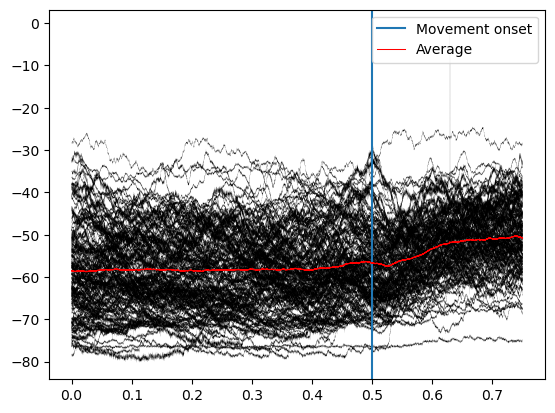

In [33]:
for i in before_data:
    plt.plot(time, i, linewidth = 0.05, color = 'black')

plt.axvline(x = 0.5, label = 'Movement onset')
plt.plot(time, np.mean(before_data, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

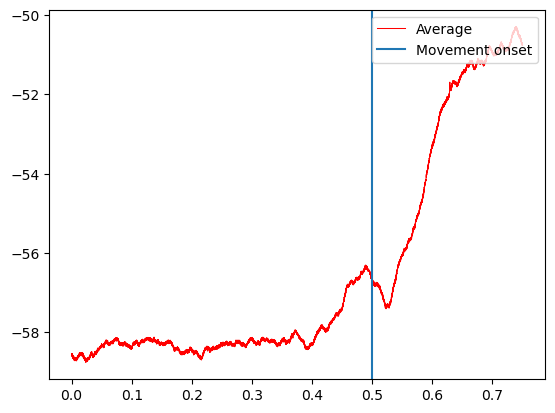

In [34]:
averages = np.mean(before_data, axis = 0)
plt.plot(time, averages, linewidth = 0.75, color = 'red', label = 'Average')
plt.axvline(x = 0.5, label = 'Movement onset')
plt.legend(loc = 'upper right')
plt.show()

In [35]:
after_data = read_event_data(sample_ids = samples['SID'], time_shift = 0.5, event_length = 0.25)
time = np.array(range(0, int(0.75 * 20_000) + 1, 1)) / 20_000
sfreq = 20_000 # Hz

Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping


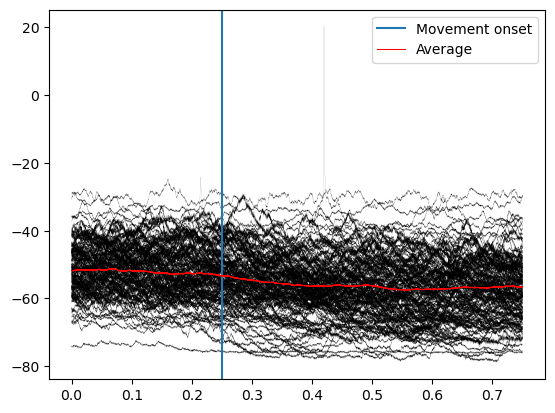

In [36]:
for i in after_data:
    plt.plot(time, i, linewidth = 0.05, color = 'black')

plt.axvline(x = 0.25, label = 'Movement onset')
plt.plot(time, np.mean(after_data, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

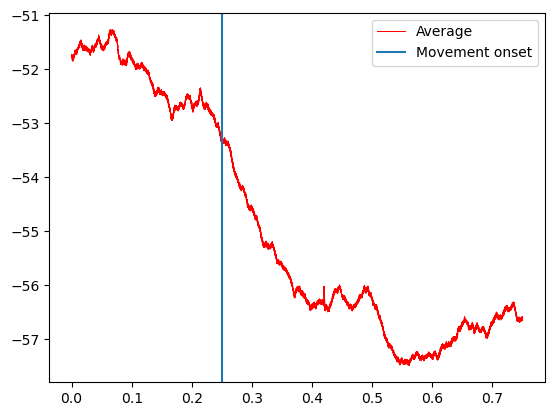

In [37]:
averages = np.mean(after_data, axis = 0)
plt.plot(time, averages, linewidth = 0.75, color = 'red', label = 'Average')
plt.axvline(x = 0.25, label = 'Movement onset')
plt.legend(loc = 'upper right')
plt.show()

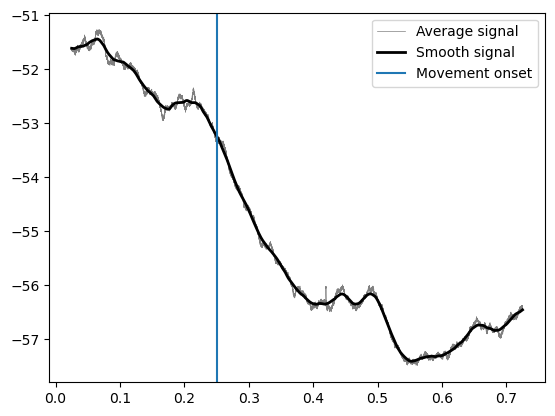

In [38]:
average = np.mean(after_data, axis = 0)
window_size = 500
smooth = np.convolve(average, np.ones(window_size) / window_size, mode = 'same')[ window_size:-window_size ]

plt.plot(time[window_size:-window_size], average[ window_size:-window_size ], linewidth = 0.5, color = 'gray', label = 'Average signal')
plt.plot(time[window_size:-window_size], smooth, linewidth = 2, color = 'black', label = 'Smooth signal')
plt.axvline(x = 0.25, label = 'Movement onset')
plt.legend(loc = 'upper right')
plt.show()